# Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install unrar
!unrar  x "/content/drive/MyDrive/Resources/EchoNet-Dynamic_Cases.rar" -d ./

Streaming output truncated to the last 5000 lines.
Extracting  ./EchoNet-Dynamic/Cases/0X93ECC18675FEC51/0X93ECC18675FEC51_ES_gt.raw      89%  OK 
Creating    ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE                 OK
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE/0X93ED1CF2689DBEE_ED.mhd      89%  OK 
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE/0X93ED1CF2689DBEE_ED.raw      89%  OK 
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE/0X93ED1CF2689DBEE_ED_gt.mhd      89%  OK 
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE/0X93ED1CF2689DBEE_ED_gt.raw      89%  OK 
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE/0X93ED1CF2689DBEE_ES.mhd      89%  OK 
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE/0X93ED1CF2689DBEE_ES.raw      89%  OK 
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF2689DBEE/0X93ED1CF2689DBEE_ES_gt.mhd      89%  OK 
Extracting  ./EchoNet-Dynamic/Cases/0X93ED1CF268

In [5]:
!git clone --branch migration_tf_data https://github.com/iamsoroush/lv-seg.git

Cloning into 'lv-seg'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 344 (delta 193), reused 240 (delta 89), pack-reused 0
Receiving objects: 100% (344/344), 208.98 KiB | 7.21 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [6]:
!pip install abstractions-aimedic --upgrade

In [7]:
pip install SimpleITK

# Dataset loading

In [1]:
import sys
sys.path.append('lv-seg')
from src.utils import load_config_file


config_path = '/content/lv-seg/runs/template/config.yaml'
config = load_config_file(config_path)
data_path = '/content/EchoNet-Dynamic'

from src.dataset.data_loader import EchoNetDataLoader


dataset_obj = EchoNetDataLoader(data_path , config)
train_gen, train_n_iter = dataset_obj.create_training_generator()
val_gen, val_n_iter = dataset_obj.create_validation_generator()
test_gen, test_n_iter = dataset_obj.create_test_generator()



0
112
(112, 112)


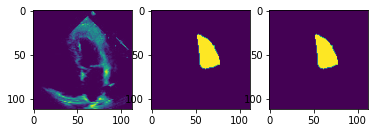

In [2]:
 import matplotlib.pyplot as plt
 for i, ele in zip(range(0, 1), train_gen):
    print(i)
    print(len(ele[0]))
    print(ele[0].numpy().shape)
    first_img = ele[0]
    img_label = ele[1]
    img_weights = ele[2]
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(first_img)
    ax[1].imshow(img_label)
    ax[2].imshow(img_weights)
    plt.show()

# Augmentation

In [2]:
from importlib import reload
from src.dataset import aug 
reload(aug)

aug_obj = augmentation.Augmentor(config)

aug_dataset_train = aug_obj.add_augmentation(train_gen)
aug_dataset_val = aug_obj.add_augmentation(val_gen)

0
112
(112, 112)


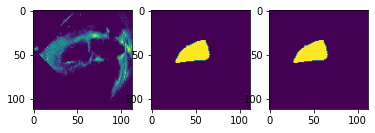

In [4]:
 for i, ele in zip(range(0, 1), aug_dataset_train):
    print(i)
    print(len(ele[0]))
    print(ele[0].numpy().shape)
    first_img = ele[0]
    img_label = ele[1]
    img_weights = ele[2]
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(first_img)
    ax[1].imshow(img_label)
    ax[2].imshow(img_weights)
    plt.show()

# Preprocessing

In [3]:
from importlib import reload
from src.dataset import preprocessing 
reload(preprocessing)

preprocessor = preprocessing.PreprocessorTF(config)

pre_dataset_train, n_iter_train = preprocessor.add_preprocess(aug_dataset_train , train_n_iter)
pre_datagen_val , val_n_iter = preprocessor.add_preprocess(aug_dataset_val , val_n_iter)

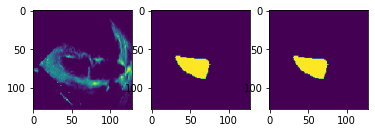

In [6]:
 import tensorflow as tf
 for i, ele in zip(range(0, 1), pre_dataset_train):
    # print(i)
    # print(len(ele[0]))
    # print(ele[0].numpy().shape)
    first_img = ele[0]
    first_img = tf.squeeze(first_img)
    img_label = ele[1]
    img_label = tf.squeeze(img_label)
    img_weights = ele[2]
    img_weights = tf.squeeze(img_weights)
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(first_img[0])
    ax[1].imshow(img_label[0])
    ax[2].imshow(img_weights[0])
    plt.show()

# Train

In [4]:
import sys
sys.path.append('lv-seg')
from src.utils import load_config_file

from src.model.baseline import UNetBaselineBuilder

from abstractions import Trainer
from abstractions.utils import setup_mlflow
from abstractions.utils import setup_mlflow
import pathlib
import os

run_name = 'train1'

repo_root = pathlib.Path('test_run')
run_dir = repo_root.joinpath('runs').joinpath(run_name)
config_path = run_dir.joinpath('config.yaml')
config_2=load_config_file(config_path)

model_builder = UNetBaselineBuilder(config_2)
MLFLOW_TRACKING_URI = 'mlruns'

trainer = Trainer(config=config_2, run_dir=run_dir)
mlflow_active_run = setup_mlflow(mlflow_tracking_uri=MLFLOW_TRACKING_URI,
                                mlflow_experiment_name=config_2.project_name,
                                base_dir=run_dir)

trainer.train(model_builder=model_builder,
                active_run=mlflow_active_run,
                train_data_gen=pre_dataset_train,
                n_iter_train=n_iter_train,
                val_data_gen=pre_datagen_val,
                n_iter_val=val_n_iter)

2021/11/29 18:54:14 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/30


2021/11/29 18:54:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='8' for run ID='b09fbb7a544749d78d36ab25ea999c4c'. Attempted logging new value 'None'.


KeyboardInterrupt: ignored

# Test

In [2]:
import sys
sys.path.append('lv-seg')
!python -m pytest /content/lv-seg/src/dataset/test/aug_test.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-3.6.4, py-1.11.0, pluggy-0.7.1
rootdir: /content, inifile:
plugins: typeguard-2.7.1
collected 1 item                                                               

lv-seg/src/dataset/test/aug_test.py .                                    [100%]

=========================== 1 passed in 5.31 seconds ===========================


In [3]:
!python -m pytest /content/lv-seg/src/dataset/test/data_loader_test.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-3.6.4, py-1.11.0, pluggy-0.7.1
rootdir: /content, inifile:
plugins: typeguard-2.7.1
collected 4 items                                                              

lv-seg/src/dataset/test/data_loader_test.py ....                         [100%]

=========================== 4 passed in 7.99 seconds ===========================


In [1]:
!python -m pytest /content/lv-seg/src/dataset/test/preprocessing_test.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-3.6.4, py-1.11.0, pluggy-0.7.1
rootdir: /content, inifile:
plugins: typeguard-2.7.1
collected 7 items                                                              

lv-seg/src/dataset/test/preprocessing_test.py .......                    [100%]

=========================== 7 passed in 8.19 seconds ===========================
